# Tiny NeRF with Flax

<a href="https://colab.research.google.com/github/myagues/flax_nerf/blob/main/tiny_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*, using Flax and supporting multiple device TPU or GPU training.

Original work:
- [Project Website](https://www.matthewtancik.com/nerf)
- [arXiv Paper](https://arxiv.org/abs/2003.08934)
- [Full Code](https://www.github.com/bmild/nerf)

Components not included in the notebook:
- 5D input including view directions
- Hierarchical Sampling

In [ ]:
!pip install -q -U flax jax

In [1]:
import functools
import os
import time

import imageio
import ipywidgets as widgets
import jax
import matplotlib.pyplot as plt
import numpy as np
import optax

from flax import jax_utils, linen as nn, optim
from flax.training import common_utils, train_state
from jax import numpy as jnp, lax
from jax.config import config
from typing import Any, Callable, Sequence

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# if running on Colab with TPUs
if "COLAB_TPU_ADDR" in os.environ:
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()

print(jax.local_devices())

[CpuDevice(id=0)]


Images shape: (100, 100, 100, 3)
Poses shape: (100, 4, 4)
Focal value: 138.88888


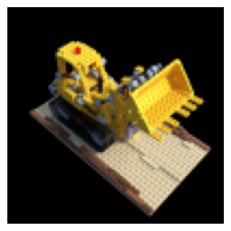

In [3]:
if not os.path.exists("tiny_nerf_data.npz"):
    !curl -O -L https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

data = np.load("tiny_nerf_data.npz")
images = data["images"]
poses = data["poses"]
focal = float(data["focal"])
_, img_h, img_w, _ = images.shape

testimg, testpose = images[101], poses[101]
images = images[:100, ..., :3]
poses = poses[:100]

print(f"Images shape: {images.shape}")
print(f"Poses shape: {poses.shape}")
print(f"Focal value: {focal:.5f}")

plt.imshow(testimg)
plt.axis("off")
plt.show()

## Optimize NeRF

In [4]:
def get_rays(img_h, img_w, focal, c2w):
    """Generate ray matrices."""
    i, j = np.meshgrid(np.arange(img_w), np.arange(img_h), indexing="xy")
    k = -np.ones_like(i)
    i = (i - img_w * 0.5) / focal
    j = -(j - img_h * 0.5) / focal
    dirs = np.stack([i, j, k], axis=-1)
    rays_d = np.einsum("ijl,kl", dirs, c2w[:3, :3])
    rays_o = np.broadcast_to(c2w[:3, -1], rays_d.shape)
    return np.stack([rays_o, rays_d])


def render_rays(
    net_fn,
    rays,
    near=2.0,
    far=6.0,
    num_samples=64,
    batch_size=10000,
    rng=None,
):
    rays_o, rays_d = rays
    # Compute 3D query points
    z_vals = np.linspace(near, far, num_samples)
    z_shape = rays_o.shape[:-1] + (num_samples,)
    if rng is not None:
        z_vals += jax.random.uniform(rng, z_shape) * (far - near) / num_samples
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Run network
    raw = lax.map(net_fn, jnp.reshape(pts, [-1, batch_size, 3]))
    raw = jnp.reshape(raw, pts.shape[:-1] + (4,))

    # Compute opacities and colors
    sigma_a = nn.relu(raw[..., 3])
    rgb = nn.sigmoid(raw[..., :3])

    # Do volume rendering
    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = jnp.concatenate(
        [dists, np.broadcast_to([1e10], dists[..., :1].shape)], axis=-1
    )

    alpha = 1.0 - jnp.exp(-sigma_a * dists)
    alpha_ = jnp.clip(1.0 - alpha, 1e-10, 1.0)
    trans = jnp.concatenate([jnp.ones_like(alpha_[..., :1]), alpha_[..., :-1]], -1)
    weights = alpha * jnp.cumprod(trans, -1)  # (img_h, img_w, num_samples)

    rgb_map = jnp.einsum("...k,...kl", weights, rgb)
    depth_map = jnp.einsum("...k,...k", weights, z_vals)
    acc_map = jnp.einsum("...k->...", weights)

    return rgb_map, depth_map, acc_map

If you try to increase `num_samples` for better quality, out of memory (OOM) errors can appear when using TPUs (TPUv2 in Colab has 8GB of HBM memory per core, whereas GPUs range from 12GB to 16GB), as they use a padding mechanism (read the [TPU performance guide](https://cloud.google.com/tpu/docs/performance-guide#consequences_of_tiling) for more information). To work around these limitations, you can:
- reduce `net_width` and / or `net_depth` (worse results)
- enable `nn.remat` decorator (slower time per step). More about `jax.remat` in [JAX #1749](https://github.com/google/jax/pull/1749).

In [5]:
class NeRF(nn.Module):
    net_depth: int = 8
    net_width: int = 256
    skips: Sequence[int] = (4,)
    periodic_fns: Sequence[Callable] = (jnp.sin, jnp.cos)
    out_channels: int = 4
    use_embedding: bool = True
    l_embed: int = 6
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT

    def embed(self, inputs):
        batch_size, _ = inputs.shape
        inputs_freq = jax.vmap(lambda x: inputs * 2.0 ** x)(jnp.arange(self.l_embed))
        fns = jnp.stack([fn(inputs_freq) for fn in self.periodic_fns])
        fns = fns.swapaxes(0, 2).reshape([batch_size, -1])
        fns = jnp.concatenate([inputs, fns], axis=-1)
        return fns

    # @nn.remat
    @nn.compact
    def __call__(self, inputs_pts):
        x = self.embed(inputs_pts) if self.use_embedding else inputs_pts
        for i in range(self.net_depth):
            x = nn.Dense(self.net_width, dtype=self.dtype, precision=self.precision)(x)
            x = nn.relu(x)
            if i in self.skips:
                x = jnp.concatenate([x, inputs_pts], axis=-1)
        x = nn.Dense(self.out_channels, dtype=self.dtype, precision=self.precision)(x)
        return x


def initialized(key, input_pts_shape):
    model = NeRF()
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    return model, initial_params["params"]

In [10]:
def train_step(state, batch, rng):
    """Train step."""
    inputs, targets = batch

    def loss_fn(params):
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        rgb, *_ = render_rays(model_fn, inputs, rng=rng)
        return jnp.mean((rgb - targets)**2)

    grads = jax.grad(loss_fn)(state.params)
    grads = lax.pmean(grads, axis_name="batch")
    new_state = state.apply_gradients(grads=grads)
    return new_state


@jax.jit
def evaluate(state):
    """Evaluation step w/ PSNR metric."""
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    rgb, *_ = render_rays(model_fn, test_rays)
    loss = jnp.mean((rgb - testimg)**2)
    psnr = -10.0 * jnp.log(loss) / jnp.log(10.0)
    return rgb, psnr


p_train_step = jax.pmap(train_step, axis_name="batch")

train_rays = np.stack(list(map(lambda x: get_rays(img_h, img_w, focal, x), poses)))
test_rays = get_rays(img_h, img_w, focal, testpose)

In [ ]:
n_devices = jax.local_device_count()
key, rng = jax.random.split(jax.random.PRNGKey(0))

model, params = initialized(key, (10000, 3))
tx = optax.adam(learning_rate=5e-4)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
state = jax.device_put_replicated(state, jax.local_devices())

psnrs = []
num_iters = 1000
i_plot = 50

for step in range(num_iters + 1):
    t = time.time()
    rng_idx, rng_step = jax.random.split(jax.random.fold_in(rng, step))
    sharded_rngs = common_utils.shard_prng_key(rng_step)

    idx = jax.random.randint(rng_idx, (n_devices,), minval=0, maxval=len(train_rays))
    batch = train_rays[tuple(idx), ...], images[tuple(idx), ...]
    state = p_train_step(state, batch, sharded_rngs)

    if step % i_plot == 0:
        t_end = time.time() - t
        state_ = jax_utils.unreplicate(state)
        rgb, psnr = evaluate(state_)
        print(f"Iters: {step:4d}\t{t_end:2.5f} sec/iter\tPSNR: {psnr:.5f}")
        psnrs.append(np.asarray(psnr))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        ax1.imshow(rgb)
        ax1.axis("off")
        ax2.plot(np.arange(0, step + 1, i_plot), psnrs)
        plt.show()

state = jax_utils.unreplicate(state)

## Interactive Visualization

In [ ]:
trans_t = lambda t: np.asarray(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
)

rot_phi = lambda phi: np.asarray(
    [
        [1, 0, 0, 0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi), np.cos(phi), 0],
        [0, 0, 0, 1],
    ]
)

rot_theta = lambda th: np.asarray(
    [
        [np.cos(th), 0, -np.sin(th), 0],
        [0, 1, 0, 0],
        [np.sin(th), 0, np.cos(th), 0],
        [0, 0, 0, 1],
    ]
)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi / 180.0 * np.pi) @ c2w
    c2w = rot_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


@jax.jit
def get_rgb(rays):
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    rgb, depth, acc = render_rays(model_fn, rays)
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc


def f(**kwargs) -> None:
    c2w = pose_spherical(**kwargs)
    rays = get_rays(img_h, img_w, focal, c2w[:3, :4])
    img, *_ = get_rgb(rays)

    plt.figure(2, figsize=(20, 6))
    plt.imshow(np.asarray(img))
    plt.axis("off")
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(value=v, min=mi, max=ma, step=0.01)

names = [
    ["theta", [100.0, 0.0, 360]],
    ["phi", [-30.0, -90, 0]],
    ["radius", [4.0, 3.0, 5.0]],
]

interactive_plot = widgets.interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = "475px"
interactive_plot

## Render 360 Video

In [ ]:
video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
v_c2w = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
rays = np.stack(list(map(lambda x: get_rays(img_h, img_w, focal, x[:3, :4]), v_c2w)))
frames, *_ = lax.map(get_rgb, rays)
frames = map(np.asarray, frames)

file_name = "video.mp4"
imageio.mimwrite(file_name, tuple(frames), fps=30, quality=7)

In [ ]:
# %%HTML
# <video width="500" controls autoplay loop>
#   <source src="video.mp4" type="video/mp4">
# </video>

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("video.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
HTML(
    """
<video width=500 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)